In [1]:
import pandas as pd
import numpy as np
import os
import random
import itertools
from pathlib import Path

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import silhouette_score

In [2]:
# Load final exam and assignment data
data = pd.DataFrame(columns=['SubjectID', 'Assignment', 'CodeStateID'])
grades = {}
scores = {}
total_non_compile = 0
data_dir = Path.cwd() / 'data'
for directory in [data_dir / 'F19_All' / 'Train', data_dir / 'S19_All']:
  grade_data = pd.read_csv(directory / 'Data' / 'LinkTables' / 'Subject.csv')
  for row in grade_data.itertuples():
    grades[row.SubjectID] = row._2 if directory.name == 'S19_All' else row._2 / 100
  main = pd.read_csv(directory / 'Data' / 'MainTable.csv')
  total_non_compile += len(main['CodeStateID'].unique())
  for row in main[main['EventType'] == 'Run.Program'].itertuples():
    scores[row.CodeStateID] = row.Score
  main['Assignment'] = [f'{int(x[0])}-{int(x[1])}' for x in list(zip(main['AssignmentID'], main['ProblemID']))]
  data = pd.concat([data, main[['SubjectID', 'Assignment', 'CodeStateID']]], ignore_index=True)

data['Score'] = [scores[x] for x in data['CodeStateID']]
data['ExamGrade'] = [grades[x] if x in grades else 0 for x in data['SubjectID']]
data = data[data['Score'] == 1]
data.head()

,SubjectID,Assignment,CodeStateID,Score,ExamGrade
0,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,439-1,79c9e2da9bc703116d8768297056db22866c43d583e529...,1.0,0.97
1,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,439-1,79c9e2da9bc703116d8768297056db22866c43d583e529...,1.0,0.97
2,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,439-3,0e91ae5696da0d6a724380360147b8699a25c14ff46227...,1.0,0.97
3,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,439-3,0e91ae5696da0d6a724380360147b8699a25c14ff46227...,1.0,0.97
4,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,439-5,1b38c7b1c7ebca281bbbc270d1b896484de663045c715f...,1.0,0.97


In [3]:
random.seed(1)
code_ids = data['CodeStateID']
assignments = data['Assignment']
assign_c = {}
unique_assignments = data['Assignment'].unique()
for assign in unique_assignments:
  assign_c[assign] = (random.random(), random.random(), random.random())
assign_lookup = {}
for c_id, assign in zip(code_ids, assignments):
  assign_lookup[c_id] = assign

In [4]:
canonicalization_strats = ['full', 'part', 'none', 'orig']
canonicalized_vectors = ['deepwalk', 'node2vec']

In [5]:
embedding_vectors = [
  ('code2vec', 384),
  ('tf_idf', 50)
]

for strat, vec_file in itertools.product(canonicalization_strats, canonicalized_vectors):
  embedding_vectors.append(
    (
      f'{strat}Canonicalization{vec_file}',
      50
    )
  )

In [6]:
vector_dir = Path.cwd() / 'data' / 'Vectors'
vector_files = [(vector_dir / f'{f}.csv', s) for f, s in embedding_vectors]

In [7]:
# def assign_colors(frame, vector_size):
#   frame = frame[[x in assign_lookup for x in frame['CodeStateID']]]
#   vectors = frame.iloc[:,0:vector_size]
#   pca = PCA(random_state=1, n_components=2)
#   pca.fit(vectors)
#   vectors = pca.transform(vectors)
#   plt.scatter(vectors[:,0], vectors[:,1], marker='.', s=1, c=[assign_c[assign_lookup[x]] for x in frame['CodeStateID']])
#   plt.show()
#   sill_scores = {'data/Vectors/deepwalk.csv': -0.25236, 'data/Vectors/code2vec.csv': -0.16918, 'data/Vectors/node2vec.csv': -0.25136, 'data/Vectors/tf_idf.csv': 0}
#   print(f'Silhouette Score: {sill_scores[file]}')

In [8]:
def heat_map(frame, vector_size):
  PROBLEMS = ['439-236', '487-20', '439-232', '439-234']
  random.seed(1)
  vector_map = {}
  vectors = np.array(frame.iloc[:,0:vector_size])
  c_ids = frame['CodeStateID']
  for v, c in zip(vectors, c_ids):
    vector_map[c] = v
  NUM_VECTORS = 100
  filt = data[[x in vector_map for x in data['CodeStateID']]]
  chosen_vectors = []
  chosen_ids = []
  for problem in PROBLEMS:
    filt2 = filt[filt['Assignment'] == problem].reset_index()
    chosen_ids += random.sample(list(filt2['CodeStateID']), 10)
  chosen_vectors = [vector_map[x] for x in chosen_ids]
  distances = np.zeros((len(chosen_vectors), len(chosen_vectors)))
  for i in range(len(chosen_vectors)):
    for j in range(i, len(chosen_vectors)):
      dist = np.linalg.norm(chosen_vectors[i] - chosen_vectors[j])
      distances[i][j] = dist
      distances[j][i] = dist
  heatmap(distances)
  plt.show()
#   print(chosen_ids)

Ideal heat map


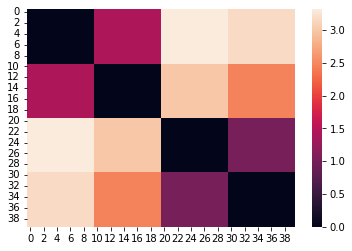

In [9]:
print("Ideal heat map")
vectors = []
distances = np.zeros((40, 40))
for i in range(10):
  vectors.append(np.array([0, 1, 1]))
for i in range(10):
  vectors.append(np.array([1, 2, 1]))
for i in range(10):
  vectors.append(np.array([3, 0, 0]))
for i in range(10):
  vectors.append(np.array([3, 1, 0]))
for i in range(len(vectors)):
  for j in range(i, len(vectors)):
    dist = np.linalg.norm(vectors[i] - vectors[j])
    distances[i][j] = dist
    distances[j][i] = dist
heatmap(distances)
plt.show()

In [10]:
# assign_colors('data/Vectors/tf_idf.csv', 50)
# assign_colors('data/Vectors/code2vec.csv', 384)
# assign_colors('data/Vectors/deepwalk.csv', 50)
# assign_colors('data/Vectors/node2vec.csv', 50)

code2vec


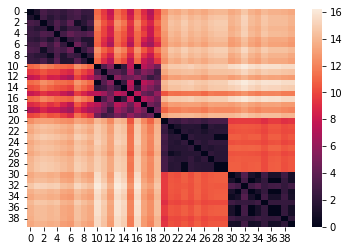

tf_idf


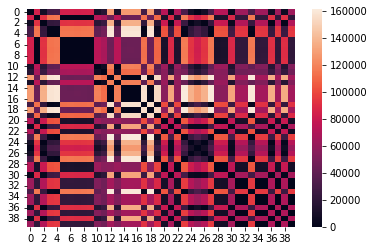

fullCanonicalizationdeepwalk


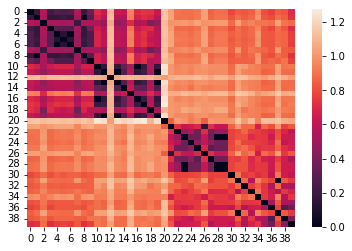

fullCanonicalizationnode2vec


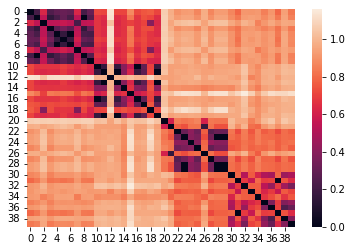

partCanonicalizationdeepwalk


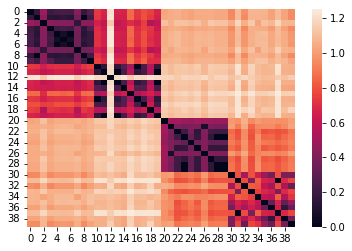

partCanonicalizationnode2vec


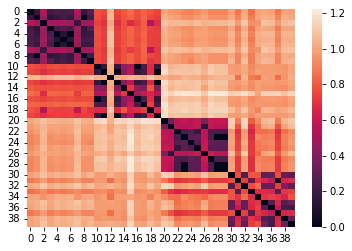

noneCanonicalizationdeepwalk


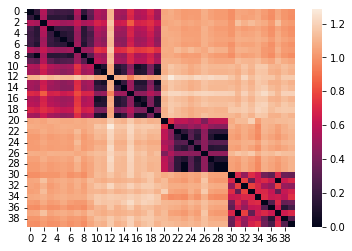

noneCanonicalizationnode2vec


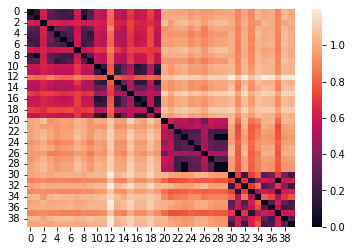

origCanonicalizationdeepwalk


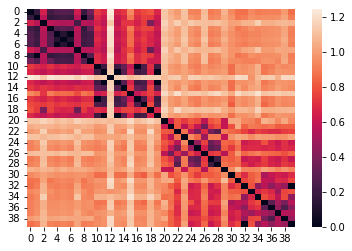

origCanonicalizationnode2vec


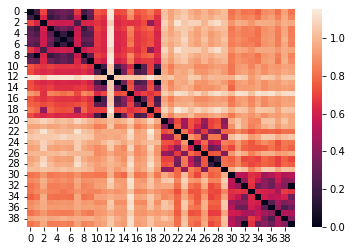

In [11]:
for file, size in vector_files:
    print(file.stem)
    heat_map(pd.read_csv(file), size)